In [162]:
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure

%matplotlib notebook

In [163]:
# Set True if you want to trace the parsing process
trace_parsing = False

In [164]:
def read_model_file(filename, trace_pasing):
    coords = np.empty((0, 3))
    with open(filename) as f:
        line = f.readline()
        model_to_coords = {}
        current_model = -1
        while line:
            words = line.strip().split(' ')
            if len(words) > 0:
                if words[0] == "MODEL":
                    current_model = words[1]
                    if trace_parsing:
                        print("Current models is: MODEL", current_model)
                elif words[0] == "ATOM":
                    if current_model == -1:
                        raise NameError('Unkown model with MODEL={current_model}')
                    x, y, z = 0, 0, 0
                    coord_starts = [6, 7, 8]
                    last_nonempty = 0
                    for idx, word in enumerate(words):
                        if len(word.strip()) > 0:
                            last_nonempty += 1
                            if last_nonempty == coord_starts[0]:
                                x = word
                            elif last_nonempty == coord_starts[1]:
                                y = word
                            elif last_nonempty == coord_starts[2]:
                                z = word
                    current_model_coords = np.array([[x, y, z]])
                    if trace_parsing:
                        print(f'Atom coords for MODEL={current_model} is {current_model_coords}')
                    coords = np.append(coords, current_model_coords, axis=0)
                elif words[0] == "ENDMDL":
                    model_to_coords[int(current_model)] = coords.astype(np.float64)
                    if trace_parsing:
                        print(f'Finished MODEL={current_model}')
                    current_model = -1
            line = f.readline()
    return model_to_coords

In [165]:
def read_reslog_file(filename):
    model_to_use = []
    with open(filename) as f:
        line = f.readline()
        while line:
            words = [w for w in line.strip().split(' ') if w]
            if len(words) == 4:
                if float(words[2]) <= 2.0:
                    model_to_use.append(int(words[0]))
            line = f.readline()
    return model_to_use

In [166]:
def calculate_model_mean(model):
    return np.mean(model, axis=0, dtype=np.float64).reshape(1, 3)

In [184]:
def calculate_centers(rootdir):
    # [(cycle_number, model_number, model_mean_vector)]
    centers = list(tuple())
    dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
    for subdir, dirs, filenames in os.walk(rootdir):
        if subdir == rootdir:
            continue
            
        print("===")
        
        reslog = os.path.join(subdir, [f for f in filenames if f.endswith(".log")][0])
        pdbqt = os.path.join(subdir, [f for f in filenames if f.endswith(".pdbqt")][0])
        print(f'Current directory is "{subdir}"')
        print(f'Current reslog file is "{reslog}"')
        print(f'Current model file is "{pdbqt}"')

        model_keys_to_use = read_reslog_file(reslog)
        print(f'Following models will be used {model_keys_to_use}')
        
        models_all = read_model_file(pdbqt, trace_parsing)
        models_to_use = dictfilt(models_all, model_keys_to_use)
        for model_key, model in models_to_use.items():
            model_mean = calculate_model_mean(model)
            centers.append((subdir, model_key, model_mean))
        print("===")
        
    return centers

In [201]:
models = calculate_centers("./data/")
# for cycle, model_number, model_mean in models:
#     print (f'cycle={cycle}, model_number={model_number}, model_mean={model_mean}')

===
Current directory is "./data/3"
Current reslog file is "./data/3/res.log"
Current model file is "./data/3/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 9]
===
===
Current directory is "./data/2"
Current reslog file is "./data/2/res.log"
Current model file is "./data/2/Str-2 3D_out.pdbqt"
Following models will be used [1, 8]
===
===
Current directory is "./data/1"
Current reslog file is "./data/1/res.log"
Current model file is "./data/1/Str-2_3D_out.pdbqt"
Following models will be used [1, 5, 9]
===
===
Current directory is "./data/5"
Current reslog file is "./data/5/res.log"
Current model file is "./data/5/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 5, 9]
===
===
Current directory is "./data/4"
Current reslog file is "./data/4/res.log"
Current model file is "./data/4/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 5, 9]
===


<IPython.core.display.Javascript object>


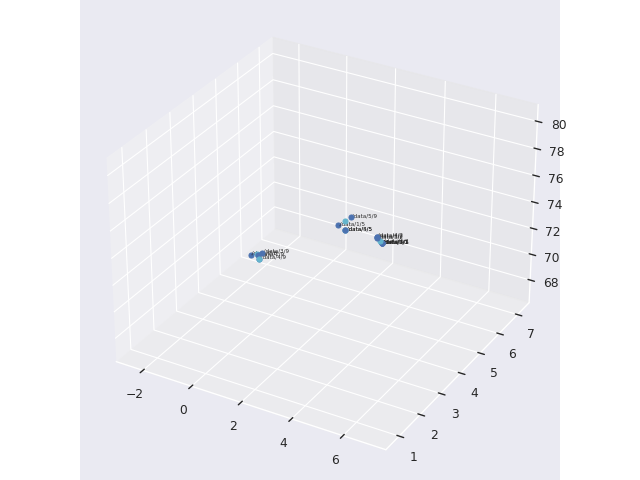

In [199]:
# TODO #clusters=5
# TODO Show error by cluster
# TODO 3D plot, each cluster has different color
# TODO Which model from a cycle contained in a current cluster

means = np.empty((0, 3))
for _, _, center in models:
    means = np.append(means, center, axis=0)

kmeans = KMeans(n_clusters=5)
kmeans.fit(means)

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

for cycle, model_number, model_mean in models:
    ax.scatter(model_mean[:, 0], model_mean[:, 1], model_mean[:, 2], color='b')
    ax.text(float(model_mean[:, 0]), 
            float(model_mean[:, 1]),
            float(model_mean[:, 2]), '%s/%s' % (cycle,model_number), size=5)

centers = kmeans.cluster_centers_
for center in centers:
    ax.scatter(center[0], center[1], center[2], color='c')


In [208]:
y_kmeans = kmeans.predict(means)
cluster_to_models = {}

# for cycle, model_number, model_mean in models:
#     print (f'cycle={cycle}, model_number={model_number}, model_mean={model_mean}')

# for idx in range(len(models)):
#     print(models[idx])
    
for idx in range(len(models)):
    if y_kmeans[idx] in cluster_to_models:
        cluster_to_models[y_kmeans[idx]].append(models[idx])
    else:
        cluster_to_models[y_kmeans[idx]] = list()
        cluster_to_models[y_kmeans[idx]].append(models[idx])

for cluster, cmodels in cluster_to_models.items():
    print(f'Models in cluster {cluster} are: ')
    for model in cmodels:
        print(f'\tFrom cycle {model[0]} model {model[1]}')

Models in cluster 0 are: 
	From cycle ./data/3 model 1
	From cycle ./data/3 model 2
	From cycle ./data/2 model 1
	From cycle ./data/1 model 1
	From cycle ./data/5 model 1
	From cycle ./data/5 model 2
	From cycle ./data/4 model 1
	From cycle ./data/4 model 2
Models in cluster 2 are: 
	From cycle ./data/3 model 9
	From cycle ./data/2 model 8
	From cycle ./data/1 model 9
Models in cluster 1 are: 
	From cycle ./data/1 model 5
	From cycle ./data/5 model 9
Models in cluster 3 are: 
	From cycle ./data/5 model 5
	From cycle ./data/4 model 5
Models in cluster 4 are: 
	From cycle ./data/4 model 9
